<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F%20%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Базы/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[123]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Перезалил?', 'Да вроде бы нет...']


In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


Создадим и обучим чат-бота.
Используя три любых простых вопроса, сравним ответы сети на них на разной степени натренированности:

a) 20 эпох – удается ли боту отвечать целыми словами?

b) + 30 эпох на этой же сетке и с этими же вопросами – появился ли прогресс в качестве
ответа сети(ответ целыми предложениями разумной длины)?

c) Ещё + 50 эпох – удается ли сети выдавать ответы, “похожие на правду”?

In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################

tokenizer = Tokenizer()

# tokenizer = Tokenizer(oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('что', 4), ('не', 5), ('я', 6), ('а', 7), ('ты', 8), ('это', 9), ('да', 10), ('в', 11), ('нет', 12), ('как', 13), ('и', 14), ('вы', 15), ('ну', 16), ('с', 17), ('на', 18), ('же', 19), ('так', 20), ('он', 21), ('у', 22), ('кто', 23), ('где', 24), ('все', 25), ('мы', 26), ('то', 27), ('мне', 28), ('тебя', 29), ('меня', 30), ('здесь', 31), ('еще', 32), ('почему', 33), ('о', 34), ('там', 35), ('тебе', 36), ('есть', 37), ('его', 38), ('за', 39), ('куда', 40), ('вот', 41), ('ничего', 42), ('вас', 43), ('знаю', 44), ('чем', 45), ('но', 46), ('она', 47), ('они', 48), ('ли', 49), ('чего', 50)]
Размер словаря : 15105


Подготовка выборки

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 171   19 5710    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[14])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[14][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Составляющие щербета по-херсонски. <END>
Пример раскодированного ответа на вход : [    2 10512 10513    54 10514     3     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][1][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    2   674    20    94 10559     3     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15105)
Установленная длина вопросов на выход : 13


In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3021000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3021000     input_2[0][0]                    
_______________________________________________________________________________________

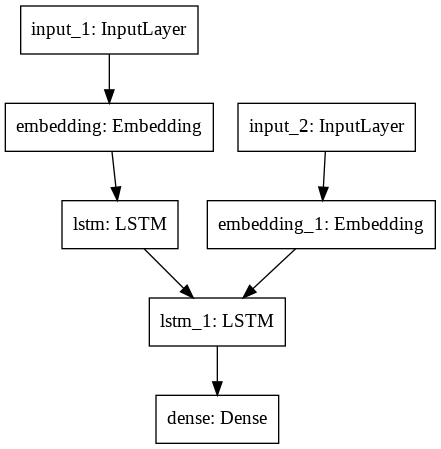

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
model.save( '/content/drive/My Drive/модели/model_30epochs(rms)_first_20_epochs.h5' )

Epoch 1/20
238/238 [==============================] - 10s 43ms/step - loss: 2.2139
Epoch 2/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9761
Epoch 3/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9275
Epoch 4/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8882
Epoch 5/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8530
Epoch 6/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8192
Epoch 7/20
238/238 [==============================] - 10s 43ms/step - loss: 1.7874
Epoch 8/20
238/238 [==============================] - 10s 43ms/step - loss: 1.7579
Epoch 9/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7281
Epoch 10/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6964
Epoch 11/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6624
Epoch 12/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6284
E

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : сколько тебе лет
 давай 
Задайте вопрос : как тебя зовут
 я 
Задайте вопрос : что думаешь
 ничего 
Задайте вопрос : знаешь что
 нет 
Задайте вопрос : когда вернешься
 не знаю 
Задайте вопрос : голоден
 ну да 


Вопросы:

1 сколько тебе лет?

2 как тебя зовут?

3 что думаешь?

4 знаешь что?

5 когда вернешься?

6 голоден?

Обучим ещё на 30 эпохах

In [ ]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 
model.save( '/content/drive/My Drive/модели/model_30epochs(rms)_second_30_epochs.h5' )

Epoch 1/30
238/238 [==============================] - 10s 43ms/step - loss: 1.3435
Epoch 2/30
238/238 [==============================] - 10s 43ms/step - loss: 1.3126
Epoch 3/30
238/238 [==============================] - 10s 43ms/step - loss: 1.2824
Epoch 4/30
238/238 [==============================] - 10s 43ms/step - loss: 1.2537
Epoch 5/30
238/238 [==============================] - 10s 42ms/step - loss: 1.2254
Epoch 6/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1984
Epoch 7/30
238/238 [==============================] - 10s 43ms/step - loss: 1.1684
Epoch 8/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1425
Epoch 9/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1178
Epoch 10/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0953
Epoch 11/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0719
Epoch 12/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0516
E

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : сколько тебе лет
 не знаю а сколько нужно 
Задайте вопрос : как тебя зовут
 меня 
Задайте вопрос : что думаешь
 ничего не надо 
Задайте вопрос : знаешь что
 а мама 
Задайте вопрос : когда вернешься
 не знаю 
Задайте вопрос : голоден
 и чего 


и ещё + 50 эпох

In [ ]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50) 
model.save( '/content/drive/My Drive/модели/model_30epochs(rms)_third_50_epochs.h5' )

Epoch 1/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8799
Epoch 2/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8757
Epoch 3/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8703
Epoch 4/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8655
Epoch 5/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8603
Epoch 6/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8553
Epoch 7/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8525
Epoch 8/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8494
Epoch 9/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8464
Epoch 10/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8433
Epoch 11/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8404
Epoch 12/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8374
E

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : сколько тебе лет
 не знаю а сколько нужно 
Задайте вопрос : как тебя зовут
 меня 
Задайте вопрос : что думаешь
 ничего 
Задайте вопрос : знаешь что
 а мама 
Задайте вопрос : когда вернешься
 сейчас 
Задайте вопрос : голоден
 и чего же он мне не чего в мне так 


# ВЫВОДЫ

**После первых 20 эпох ответы были однословными и почти не попадали под понятие "логичные"**

Задайте вопрос : сколько тебе лет

 давай 

Задайте вопрос : как тебя зовут

 я 

Задайте вопрос : что думаешь

 ничего 

Задайте вопрос : знаешь что

 нет 

Задайте вопрос : когда вернешься

 не знаю 

Задайте вопрос : голоден

 ну да


**После ещё 30 эпох ответы стали намного логичнее, однако (и скорее всего из-за моих не совсем понятных вопросов) некоторые ответы всё равно оказались не в тему.**

Задайте вопрос : сколько тебе лет

 не знаю а сколько нужно 

Задайте вопрос : как тебя зовут

 меня 

Задайте вопрос : что думаешь

 ничего не надо 

Задайте вопрос : знаешь что

 а мама 

Задайте вопрос : когда вернешься

 не знаю 

Задайте вопрос : голоден
 
 и чего

Ещё после 50 эпох разница есть, например на вопрос *КОГДА ВЕРНЕШЬСЯ?* вместо *НЕ ЗНАЮ*, сеть ответила *СЕЙЧАС*, что, как мне кажется более логично, но вот на вопрос *ГОЛОДЕН* выдает  почти не связные слова.


Задайте вопрос : сколько тебе лет
 не знаю а сколько нужно 
Задайте вопрос : как тебя зовут
 меня 
Задайте вопрос : что думаешь
 ничего 
Задайте вопрос : знаешь что
 а мама 
Задайте вопрос : когда вернешься
 сейчас 
Задайте вопрос : голоден
 и чего же он мне не чего в мне так 

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(20): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : который год
 да 
Задайте вопрос : сколько времени
 не знаю 
Задайте вопрос : ты кто
 я я 
Задайте вопрос : как твои дела
 все в порядке 
Задайте вопрос : чем занимаешься
 да я что сейчас вы теперь видели 
Задайте вопрос : где работаешь
 еще ну на 
Задайте вопрос : умеешь танцевать
 как же что это 
Задайте вопрос : любишь чай
 как это я нет 
Задайте вопрос : давай дружить
 ты это хорошо вот и да 
Задайте вопрос : когда война
 думаю да 
Задайте вопрос : куришь
 нет 
Задайте вопрос : учился в школе
 ничего 
Задайте вопрос : на каком языке говоришь
 у меня на тебе а вот и он 
Задайте вопрос : что такое хлеб
 на что то где мне ну 
Задайте вопрос : который час
 я бы тоже не могу 
Задайте вопрос : который час
 я бы тоже не могу 
Задайте вопрос : давай поговорим
 нет 
Задайте вопрос : почему
 не знаю хочешь я 
Задайте вопрос : ну и ладно
 а что 
Задайте вопрос : а ничего хорошего
 ну так он вообще сейчас 


In [ ]:
Tokenizer?

# Добьемся максимально низкого Loss’а в обучении модели




In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################

tokenizer = Tokenizer()

# tokenizer = Tokenizer(oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря

######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
def make_net(num_filters=200,):
  encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  encoderEmbedding = Embedding(vocabularySize, num_filters , mask_zero=True) (encoderInputs)
  # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
  # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
  encoderOutputs, state_h , state_c = LSTM(num_filters, return_state=True)(encoderEmbedding)
  encoderStates = [state_h, state_c]


  ######################
  # Второй входной слой, декодер, выходной слой
  ######################
  decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
  decoderEmbedding = Embedding(vocabularySize, num_filters, mask_zero=True) (decoderInputs) 
  # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
  decoderLSTM = LSTM(num_filters, return_state=True, return_sequences=True)
  decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
  # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
  decoderDense = Dense(vocabularySize, activation='softmax') 
  output = decoderDense (decoderOutputs)

  ######################
  # Собираем тренировочную модель нейросети
  ######################

  model = Model([encoderInputs, decoderInputs], output)
  return model


In [ ]:
model = make_net()
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [ ]:
def save_hist(history, PATH):
  hist_df = pd.DataFrame(history.history) 
  hist_df.to_excel(PATH)

In [ ]:
# Запустим обучение и сохраним модель
history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
model.save( '/content/drive/My Drive/модели/model_original_HW26.h5')

Epoch 1/20
238/238 [==============================] - 10s 43ms/step - loss: 2.2115
Epoch 2/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9759
Epoch 3/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9277
Epoch 4/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8896
Epoch 5/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8554
Epoch 6/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8227
Epoch 7/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7916
Epoch 8/20
238/238 [==============================] - 10s 44ms/step - loss: 1.7596
Epoch 9/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7271
Epoch 10/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6933
Epoch 11/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6588
Epoch 12/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6278
E

In [ ]:
save_hist(history, '/content/drive/MyDrive/Домашнее задание №26 истории/hist.xlsx')

Для начала попробуем поэкспериментировать с пространством Embedding на небольшом количестве эпох, потом сравним с ошибкой эталона из ноутбука

In [ ]:
for num in [220, 240, 260, 280, 300]:
  model = make_net(num_filters=num)
  model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
  model.save( f'/content/drive/My Drive/Домашнее задание №26 истории/model_embd_{num}.h5')
  save_hist(history, f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_emb_{num}.xlsx')

Epoch 1/20
238/238 [==============================] - 11s 45ms/step - loss: 2.2079
Epoch 2/20
238/238 [==============================] - 11s 45ms/step - loss: 1.9744
Epoch 3/20
238/238 [==============================] - 11s 45ms/step - loss: 1.9234
Epoch 4/20
238/238 [==============================] - 11s 45ms/step - loss: 1.8848
Epoch 5/20
238/238 [==============================] - 11s 45ms/step - loss: 1.8495
Epoch 6/20
238/238 [==============================] - 11s 45ms/step - loss: 1.8145
Epoch 7/20
238/238 [==============================] - 11s 45ms/step - loss: 1.7828
Epoch 8/20
238/238 [==============================] - 11s 45ms/step - loss: 1.7494
Epoch 9/20
238/238 [==============================] - 11s 45ms/step - loss: 1.7146
Epoch 10/20
238/238 [==============================] - 11s 45ms/step - loss: 1.6794
Epoch 11/20
238/238 [==============================] - 11s 45ms/step - loss: 1.6456
Epoch 12/20
238/238 [==============================] - 11s 45ms/step - loss: 1.6103
E

видим, что ошибка падает с увеличением размера Embedding, продолжим эксперимент

In [ ]:
for num in range(300, 500, 20):
  model = make_net(num_filters=num)
  model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
  model.save( f'/content/drive/My Drive/Домашнее задание №26 истории/model_embd_{num}.h5')
  save_hist(history, f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_emb_{num}.xlsx')

Epoch 1/20
238/238 [==============================] - 12s 52ms/step - loss: 2.1723
Epoch 2/20
238/238 [==============================] - 12s 51ms/step - loss: 1.9636
Epoch 3/20
238/238 [==============================] - 12s 51ms/step - loss: 1.9094
Epoch 4/20
238/238 [==============================] - 12s 52ms/step - loss: 1.8649
Epoch 5/20
238/238 [==============================] - 12s 51ms/step - loss: 1.8228
Epoch 6/20
238/238 [==============================] - 12s 51ms/step - loss: 1.7833
Epoch 7/20
238/238 [==============================] - 12s 51ms/step - loss: 1.7391
Epoch 8/20
238/238 [==============================] - 12s 50ms/step - loss: 1.6932
Epoch 9/20
238/238 [==============================] - 12s 50ms/step - loss: 1.6458
Epoch 10/20
238/238 [==============================] - 12s 51ms/step - loss: 1.5973
Epoch 11/20
238/238 [==============================] - 12s 51ms/step - loss: 1.5491
Epoch 12/20
238/238 [==============================] - 12s 50ms/step - loss: 1.5009
E

In [ ]:
for opt in [Adam(), Adadelta()]:
  for batch in range(50, 200, 10):
    model = make_net(num_filters=500)
    model.compile(optimizer=opt, loss='categorical_crossentropy')
    history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=batch, epochs=20) 
    model.save( f'/content/drive/My Drive/Домашнее задание №26 истории/model_opt_{opt}_batch_{batch}.h5')
    save_hist(history, f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_opt_{opt}_batch_{batch}.xlsx')

Epoch 1/20
238/238 [==============================] - 22s 94ms/step - loss: 2.2819
Epoch 2/20
238/238 [==============================] - 23s 95ms/step - loss: 1.9205
Epoch 3/20
238/238 [==============================] - 23s 95ms/step - loss: 1.8271
Epoch 4/20
238/238 [==============================] - 23s 95ms/step - loss: 1.7400
Epoch 5/20
238/238 [==============================] - 23s 95ms/step - loss: 1.6467
Epoch 6/20
238/238 [==============================] - 23s 95ms/step - loss: 1.5482
Epoch 7/20
238/238 [==============================] - 23s 97ms/step - loss: 1.4387
Epoch 8/20
238/238 [==============================] - 23s 97ms/step - loss: 1.3156
Epoch 9/20
238/238 [==============================] - 22s 94ms/step - loss: 1.1811
Epoch 10/20
238/238 [==============================] - 22s 94ms/step - loss: 1.0415
Epoch 11/20
238/238 [==============================] - 23s 95ms/step - loss: 0.8974
Epoch 12/20
238/238 [==============================] - 22s 94ms/step - loss: 0.7618
E

По результатам видно, что увеличение пространства Embedding уменьшает итоговую ошибку, а также оптимизатор Adam лучше срабатывает, чем RMSprop, теперь подберем размер батча

In [ ]:
for batch in range(20, 320, 20):
  model = make_net(num_filters=500)
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy')
  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=batch, epochs=10) 
  model.save( f'/content/drive/My Drive/Домашнее задание №26 истории/model_batch_{batch}.h5')
  save_hist(history, f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_batch_{batch}.xlsx')

Epoch 1/10
595/595 [==============================] - 50s 84ms/step - loss: 2.4894
Epoch 2/10
595/595 [==============================] - 49s 83ms/step - loss: 2.0091
Epoch 3/10
595/595 [==============================] - 49s 83ms/step - loss: 1.9579
Epoch 4/10
595/595 [==============================] - 49s 83ms/step - loss: 1.9248
Epoch 5/10
595/595 [==============================] - 49s 83ms/step - loss: 1.8970
Epoch 6/10
595/595 [==============================] - 50s 83ms/step - loss: 1.8725
Epoch 7/10
595/595 [==============================] - 50s 83ms/step - loss: 1.8488
Epoch 8/10
595/595 [==============================] - 49s 83ms/step - loss: 1.8256
Epoch 9/10
595/595 [==============================] - 50s 83ms/step - loss: 1.8007
Epoch 10/10
595/595 [==============================] - 49s 83ms/step - loss: 1.7742
Epoch 1/10
298/298 [==============================] - 30s 99ms/step - loss: 2.7564
Epoch 2/10
298/298 [==============================] - 29s 99ms/step - loss: 2.0917
Epo

In [ ]:
all_data = pd.DataFrame()
for batch in range(20, 320, 20):
  df = pd.read_excel(f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_batch_{batch}.xlsx')
  all_data[f'{batch}'] = df['loss']

In [ ]:
all_data

,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300
0,2.489378,2.756364,2.967692,3.138956,3.327331,3.498780,3.669918,3.799428,3.903911,3.949324,3.977857,3.991331,3.997227,4.001312,4.003178
1,2.009057,2.091726,2.212188,2.288288,2.321468,2.353065,2.380901,2.430278,2.524612,2.642445,2.790395,2.968255,3.126038,3.279263,3.412049
2,1.957857,1.996805,2.051809,2.137204,2.200061,2.249652,2.267210,2.291483,2.308522,2.319743,2.330280,2.344987,2.362784,2.385781,2.417864
3,1.924838,1.960872,1.998377,2.038769,2.090084,2.163049,2.198693,2.236951,2.255876,2.266106,2.272356,2.281325,2.289937,2.304222,2.317871
4,1.896997,1.932847,1.968169,1.999640,2.028443,2.075102,2.123301,2.182661,2.210331,2.226598,2.234301,2.242934,2.253206,2.267094,2.278799
5,1.872499,1.910995,1.945164,1.974864,1.998705,2.025887,2.057469,2.117846,2.155864,2.185797,2.200113,2.211080,2.224158,2.238998,2.252420
6,1.848825,1.891250,1.925139,1.953912,1.976635,2.000648,2.020827,2.060033,2.094675,2.136755,2.161730,2.178980,2.197343,2.214417,2.228781
7,1.825592,1.873355,1.907804,1.935656,1.957372,1.981958,1.998245,2.026249,2.048469,2.083228,2.114176,2.140981,2.168073,2.189061,2.205723
8,1.800675,1.856472,1.892063,1.919605,1.940367,1.965160,1.980411,2.005950,2.021254,2.042954,2.069511,2.097799,2.132324,2.158781,2.181984
9,1.774227,1.840930,1.877867,1.904970,1.924895,1.949285,1.964891,1.990484,2.003653,2.019176,2.036813,2.060467,2.092930,2.123384,2.153593


Чем меньше батч, тем меньше ошибка. Соберем наши гиперпараметры в одну сеть, 
батч = 16, оптимизатор = Адам, пространство ембединга = 500 и поставим обучени на 150 эпох

In [ ]:
model = make_net(num_filters=500)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy')
history = model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=16, epochs=150) 
model.save( f'/content/drive/My Drive/Домашнее задание №26 истории/model_best.h5')
save_hist(history, f'/content/drive/MyDrive/Домашнее задание №26 истории/hist_best.xlsx')

Epoch 1/150
744/744 [==============================] - 65s 88ms/step - loss: 2.4283
Epoch 2/150
744/744 [==============================] - 65s 87ms/step - loss: 1.9982
Epoch 3/150
744/744 [==============================] - 65s 87ms/step - loss: 1.9506
Epoch 4/150
744/744 [==============================] - 66s 88ms/step - loss: 1.9167
Epoch 5/150
744/744 [==============================] - 65s 87ms/step - loss: 1.8870
Epoch 6/150
744/744 [==============================] - 66s 88ms/step - loss: 1.8588
Epoch 7/150
744/744 [==============================] - 65s 87ms/step - loss: 1.8299
Epoch 8/150
744/744 [==============================] - 65s 88ms/step - loss: 1.7993
Epoch 9/150
744/744 [==============================] - 65s 88ms/step - loss: 1.7677
Epoch 10/150
744/744 [==============================] - 65s 88ms/step - loss: 1.7362
Epoch 11/150
744/744 [==============================] - 65s 87ms/step - loss: 1.7052
Epoch 12/150
744/744 [==============================] - 64s 87ms/step - lo